# nbjob - Example: Logistic Regression (using Theano)
[Home](index.html) | Previous: [Tutorial](tutorial.html)

[Download this document as a notebook](../doc/logreg.ipynb)

This tutorial is a modified version of [Logistic Regression Tutorial from deeplearning.net](deeplearning.net/tutorial/logreg.html). Original text and code is copyright (c) 2010-2015, Deep Learning Tutorials Development Team. The tutorial has been modified to show how the same model can be constructed and trained in a workflow that uses `nbjob`.

Theano is required to run this tutorial.

## Introduction
In this section, we're going to use Theano to implement a logistic regression classifier, and test it on the MNIST digit classification problem.

But first, we need to initialize the `nbjob` infrastructre. We start by importing `nbjob` and connecting it to the database.

In [1]:
import nbjob
from nbjob import SnippetCollector, ParamLogger, DBWrapper, DummyJobtracker

db_wrapper = DBWrapper()
jobtracker = DummyJobtracker()

Now we can begin by importing some of the Python modules we'll be using. Since we'll need most of those modules both locally and remotely, we create a `prelude` variable that records the code we.

In [2]:
prelude = SnippetCollector()

In [3]:
%%snip prelude
# Imports for both remote workers, and locally
import theano
import theano.tensor as T
import numpy as np

Now we need to configure Theano. Note how our snippet mechanism lets us have different settings for the workers and the local notebook. This means the workers can have all Theano optimizations enabled, while our local version can be configured to compile faster or to enable debug mode.

In [4]:
%%snip prelude
floatX = theano.config.floatX
theano.config.mode = 'FAST_RUN'
theano.config.optimizer = 'fast_run'

In [5]:
# Override theano settings locally
theano.config.mode = 'FAST_COMPILE'
theano.config.optimizer = 'fast_compile'

Finally, let's make some previsions for loading in data. We will store that data in `~/data`, using pickle files.

In [6]:
%%snip prelude
import pickle, os, gzip
DATA_PREFIX = os.path.expanduser('~/data')

## Downloading the MNIST dataset

Let's run the commands that will download a copy of the dataset.

In [ ]:
%%bash

pushd ~/data
wget http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz
popd

We only need to run the above command once. After that, we can verify that the file exists.

In [7]:
!ls ~/data/mnist.pkl.gz

/home/nikita/data/mnist.pkl.gz


### Loading the Dataset into Memory

Now we can create a snippet that loads the MNIST dataset

In [8]:
mnist_dataset = SnippetCollector()

@mnist_dataset
def make_shared(datasets, x_cast=None, y_cast='int32'):
    """Takes as input an iteratable of (x,y) pairs
    Each x/y is stored into a Theano shared variable
    Shared variables are better for taking advantage of the GPU"""
    res = []
    for set_x, set_y in datasets:
        set_x = theano.shared(np.asarray(set_x, dtype=floatX))
        if x_cast:
            set_x = T.cast(set_x, x_cast)
        set_y = theano.shared(np.asarray(set_y, dtype=floatX))
        if y_cast:
            set_y = T.cast(set_y, y_cast)
        res.append((set_x, set_y))
    return tuple(res)

@mnist_dataset
def load_mnist():
    import gzip
    with gzip.open(os.path.join(DATA_PREFIX, 'mnist.pkl.gz'), 'rb') as f:
        datasets = pickle.load(f, encoding='latin1')
    
    return make_shared(datasets)

In [9]:
%%snip mnist_dataset
datasets = load_mnist() # Actually load the data into memory

For our classifier later on, we need to know the dimensionality of the input vector, as well as the number of output classes

In [10]:
%%snip mnist_dataset

n_in = int(datasets[0][0].shape[1].eval()) # Dimensionality of the input vectors
n_out = 10 # We have 10 output classes, '0'...'9'

Having (at least parts of) the dataset in local memory is useful for examining it and gaining intuition.

The images in MNIST are 28x28 with float-valued pixels, so we expect the input dimensionality to be $28^2$.

In [11]:
import math
math.sqrt(n_in)

28.0

We can also visualize individual data entries in the notebook.

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

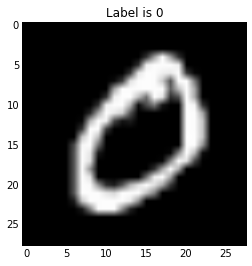

In [99]:
def draw_image(dataset, number):
    plt.imshow(dataset[0][number,:].eval().reshape((28, 28)), cmap='gray')

def get_label(dataset, number):
    return int(dataset[1][number].eval())

draw_image(datasets[0], # Training data
           1)
plt.title('Label is {}'.format(get_label(datasets[0], 1)))

## The Model

Logistic regression is a probabilistic, linear classifier. It is parametrized
by a weight matrix $W$ and a bias vector $b$. Classification is
done by projecting an input vector onto a set of hyperplanes, each of which
corresponds to a class. The distance from the input to a hyperplane reflects
the probability that the input is a member of the corresponding class.

Mathematically, the probability that an input vector $x$ is a member of a
class $i$, a value of a stochastic variable $Y$, can be written as:

$$P(Y=i|x, W,b) = softmax_i(W x + b) = \frac {e^{W_i x + b_i}} {\sum_j e^{W_j x + b_j}}$$

The model's prediction $y_{pred}$ is the class whose probability is maximal, specifically:

$$y_{pred} = {\rm argmax}_i P(Y=i|x,W,b)$$

Let's implement this in Theano.

In [14]:
model = SnippetCollector()

First we create symbolic variables for our input (x and y represent a minibatch)

In [15]:
%%snip model
x = T.matrix('x') 
y = T.ivector('y')

Then we define the core of the Logistic Regression

In [16]:
%%snip model
# initialize with 0 the weights W as a matrix of shape (n_in, n_out)
W = theano.shared(
    value=np.zeros(
        (n_in, n_out),
        dtype=floatX
    ),
    name='W',
    borrow=True
)
# initialize the biases b as a vector of n_out 0s
b = theano.shared(
    value=np.zeros(
        (n_out,),
        dtype=floatX
    ),
    name='b',
    borrow=True
)

# symbolic expression for computing the matrix of class-membership
# probabilities
# Where:
# W is a matrix where column-k represent the separation hyperplane for
# class-k
# x is a matrix where row-j  represents input training sample-j
# b is a vector where element-k represent the free parameter of
# hyperplane-k
p_y_given_x = T.nnet.softmax(T.dot(x, W) + b)

# symbolic description of how to compute prediction as class whose
# probability is maximal
y_pred = T.argmax(p_y_given_x, axis=1)

Since the parameters of the model must maintain a persistent state throughout
training, we allocate shared variables for $W$, $b$. This declares them both
as being symbolic Theano variables, but also initializes their contents. The
dot and softmax operators are then used to compute the vector $P(Y|x,
W,b)$. The result `p_y_given_x` is a symbolic variable of vector-type.

To get the actual model prediction, we can use the `T.argmax` operator, which
will return the index at which `p_y_given_x` is maximal (i.e. the class with
maximum probability).

Now of course, the model we have defined so far does not do anything useful
yet, since its parameters are still in their initial state. But we can still evaluate the model predictions to make sure the code does not raise any exceptions.

In [17]:
# Predicted label for the first two images
y_pred.eval({x: datasets[0][0][:2,:].eval()})

array([0, 0])

## Defining a Loss Function

Learning optimal model parameters involves minimizing a loss function. In the
case of multi-class logistic regression, it is very common to use the negative
log-likelihood as the loss. This is equivalent to maximizing the likelihood of the
data set $D$ under the model parameterized by $\theta$. Let
us first start by defining the log-likelihood $L$ and loss $\ell$:

$$ L(\theta=\{W,b\}, D) = \sum_{i=0}^{|D|} \log(P(Y=y^{(i)}|x^{(i)}, W,b)))$$
$$ \ell (\theta = \{W,b\}, D) = - L (\theta=\{W,b\}, D) $$

Let us define the (symbolic) loss for a given minibatch.

In [18]:
%%snip model
cost = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])

*Even though the loss is formally defined as the sum, over the data set, of individual error terms, in practice, we use the mean (`T.mean`) in the code. This allows for the learning rate choice to be less dependent of the minibatch size.*

In [19]:
# We can evaluate the cost for the first two images
# (again, this tests that there are no exceptions)
cost.eval({x: datasets[0][0][:2,:].eval(),
           y: datasets[0][1][:2].eval()})

array(2.302585092994046)

## Learning the Model

To train the model, we will use stochastic gradient descient with minibatches. 

This is a good time to bring up how `nbjob` handles hyperparameters. We use a `ParamLogger` to collect hyperparameter values. Each time we launch a job, we will have the option of adjusting the hyperparameters using slider widgets. They can also be changed using code.

In [23]:
model_sgd = SnippetCollector()
hparams = ParamLogger()

In [24]:
hparams.learning_rate = 0.01
hparams.batch_size = 500

We can use Theano to get the gradients $\partial\ell/\partial W$ and $\partial\ell/\partial b$ using Theano.

In [25]:
%%snip model_sgd
g_W, g_b = T.grad(cost, [W, b])

The function `train_model`, which performs one step of gradient descent, can then be defined as follows:

In [26]:
%%snip model_sgd
# specify how to update the parameters of the model as a list of
# (variable, update expression) pairs.
updates = [(W, W - hparams.learning_rate * g_W),
           (b, b - hparams.learning_rate * g_b)]

index = T.lscalar()  # index to a [mini]batch

train_set_x, train_set_y = datasets[0]

# compiling a Theano function `train_model` that returns the cost, but in
# the same time updates the parameter of the model based on the rules
# defined in `updates`
train_model = theano.function(
    inputs=[index],
    outputs=cost,
    updates=updates,
    givens={
        x: train_set_x[index * hparams.batch_size: (index + 1) * hparams.batch_size],
        y: train_set_y[index * hparams.batch_size: (index + 1) * hparams.batch_size]
    }
)

Again, we can test the gradient step locally to ensure that everything works as expected. (Ability to test small pieces on a regular basis is a major benefit to using Jupyter notebook over script files)

In [27]:
print('Old cost', cost.eval({x: datasets[0][0][:hparams.batch_size,:].eval(),
                             y: datasets[0][1][:hparams.batch_size].eval()}))
train_model(0)
print('New cost', cost.eval({x: datasets[0][0][:hparams.batch_size,:].eval(),
                             y: datasets[0][1][:hparams.batch_size].eval()}))

Old cost 2.3025850929940463
New cost 2.2891778790230446


After training on the first minibatch, the training cost for that exact batch has gone down. This gives us sufficient confidence that the model is correct, and we now proceed to defining the full training process that we wish to run on the remote worker.

We should register checkpoints for key variables that we wish to save through out training. These are
* For the model: model parameters
* For the training algorithm: epoch and iteration number

In [42]:
%%snip model
# We specify a getter and setter for each variable, because pickling the variables
# themselves will disconnect them from the computation graph.
def get_params():
    return W.get_value(), b.get_value()
def set_params(vals):
    global W, b
    W_val, b_val = vals
    W.set_value(W_val)
    b.set_value(b_val)
jobtracker.register_checkpointer('model_params', 'get_params', 'set_params')

# TODO(nikita): we should be able to do the following code instead,
#   but having complex expressions in the getter/setter fields is not yet supported
#   Complex expressions in the 'name' field are allowed, though.
# jobtracker.register_checkpointer('W', 'W.get_value', 'W.set_value')
# jobtracker.register_checkpointer('b', 'b.get_value', 'b.set_value')

In [29]:
%%snip model_sgd
epoch, iteration = 0, 0 # global, so they can be checkpointed
jobtracker.register_checkpointer('epoch')
jobtracker.register_checkpointer('iteration')

Then we define the entry point to our training, which will iterate over the data, update the model parameters, and periodically checkpoint

In [44]:
hparams.checkpoint_frequency = hparams.batch_size * 5
hparams.max_epochs = 10

In [58]:
@model_sgd
def sgd_train():
    global epoch, iteration # global, so they can be checkpointed
    n_train_batches = int(train_set_x.shape[0].eval() // hparams.batch_size)
    epoch = 0
    while epoch < hparams.max_epochs:
        epoch += 1
        for minibatch_index in range(n_train_batches):
            # Iteration refers to the number of training examples seen so far
            iteration = ((epoch - 1) * n_train_batches + minibatch_index) * hparams.batch_size
            minibatch_avg_cost = train_model(minibatch_index)
            if (iteration + 1) % hparams.checkpoint_frequency:
                # This saves the value of all checkpointed expressions in the database
                jobtracker.checkpoint()
                print('Minibatch average cost:', minibatch_avg_cost)

## Delegate Training Job to an IPython Cluster

At this point, make sure that an IPython Cluster is running. We are now ready to connect to it.

In [35]:
import ipyparallel as ipp
rc = ipp.Client()

Then we can delegate the training procedure to worker 0 in the cluster, denoted by `rc[0]`.

In [59]:
job = db_wrapper.create_job(
    rc[0], # Our worker
    ['sgd_train()'], # List of strings to run remotely
    prelude, mnist_dataset, model, model_sgd, # All of the snippets we wish to run
    hparams=hparams, # Our parameter values
    )

job.result # This opens a widget in our notebook that lets us view stdout from the worker

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

RemoteError: KeyError('_f4b4e4dd78c94999bee024e5ac30a033_kwargs')

When you run the code above, you will see a widget pop up that lets you adjust hyperparameters and review the code that is about to be sent to the remote job. Click "OK" to start the job, or "Cancel" if something looks wrong. Don't leave the widget open while you edit other things in the notebook: it might work, but the results aren't guaranteed.

*Note: the KeyError is not an actual important error, and does not affect using `nbjob`. TODO(nikita): figure out how to silence displaying this error*

## Plotting learning curves

For the purposes of this tutorial, the training algorithm we defined does not use the validation set. Instead, we can examine the model performance on the validation set separately, by running analyses on the job. First, we define a function that returns figures of interest in a dictionary.

In [60]:
def test_statistics():
    global epoch, iteration
    error = T.mean(T.neq(y_pred, y))
    
    valid_set_x, valid_set_y = datasets[1]
    
    validation_error = theano.function(
        inputs=[index],
        outputs=error,
        givens={
            x: valid_set_x[index * hparams.batch_size: (index+1) * hparams.batch_size],
            y: valid_set_y[index * hparams.batch_size: (index+1) * hparams.batch_size]
        }
    )
    
    current_validation_error = np.mean(
        [validation_error(i) for i in range(valid_set_x.shape[0].eval() // hparams.batch_size)]
    )
    
    return {
        'epoch': epoch,
        'iteration': iteration,
        'error': current_validation_error
    }

# Again, test locally to see that we have defined it correctly
# (unfortunately, even local testing takes a while, because the computation graph must be constructed)
test_statistics()

{'epoch': 0, 'error': 0.3871, 'iteration': 0}

Now we can start an analysis, which will calculate these statistics throughout the training process

In [61]:
analyzer = db_wrapper.create_analyzer(
    rc[1], # A different worker, so it can run even if training is still ongoing
    job,
    [test_statistics])
analyzer.result

<AsyncResult: remote_start_analyzer>

RemoteError: KeyError('_fc3184bc53484632a959c702f62ba40a_kwargs')

We can monitor the progress of our job and analysis from the dashboard.

In [41]:
# Unfortunately, widgets are not rendered in the HTML version of this notebook
nbjob.make_default_dashboard()

We can also inspect the progress by querying the analyzer for a list of output dictionaries, and then plotting the learning curve.

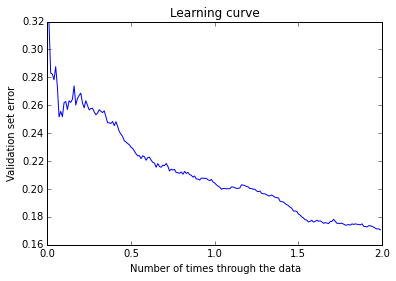

In [101]:
# If the analyzer is not done, this graph will not plot the entire duration of training
xs = []
ys = []
iterations_per_epoch = datasets[0][0].shape[0].eval()
for d in analyzer.get_results():
    xs.append(d['iteration'] / iterations_per_epoch)
    ys.append(d['error'])
plt.title('Learning curve')
plt.xlabel('Number of times through the data')
plt.ylabel('Validation set error')
plt.plot(xs, ys)

## Predicting using the final trained model

`nbjob` also lets us inspect quantities related to the final trained model. To do this, we first make sure one of the workers is holding the job in memory. At the moment `rc[0]` has a copy of the model (because it was used for training), as does `rc[1]` (assuming the analysis ran to completion).

We use `ipyparallel`'s capability to issue commands to a remote worker.

In [76]:
rc[0].activate('_0') # This creates the cell magic %%px_0, which addresses worker 0

In [94]:
%%px_0
index_start = 0
index_end = 5
indices = range(index_start, index_end)
predicted = y_pred.eval({x: datasets[1][0][index_start:index_end,:].eval()})
predicted

<AsyncResult: execute>

Out[0:41]: array([3, 8, 6, 9, 6])

`ipyparellel` provides a nice syntax for pulling remote variables into the local namespace:

In [95]:
rc[0]['predicted']

array([3, 8, 6, 9, 6])

We can use this to visualize the results (this is run locally so we don't have to enable matplotlib on the worker)

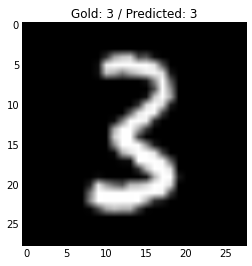

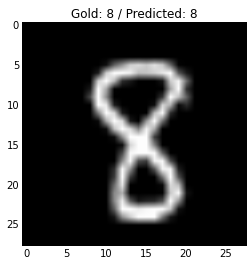

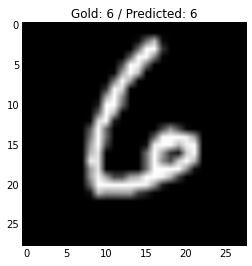

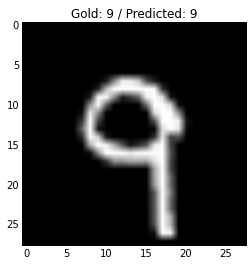

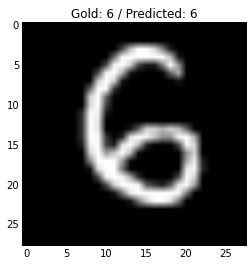

In [96]:
def viz_prediction(dataset, number, pred):
    plt.figure()
    plt.imshow(dataset[0][number,:].eval().reshape((28, 28)), cmap='gray')
    plt.title('Gold: {} / Predicted: {}'.format(
            dataset[1][number].eval(),
            pred
        ))

for i, p in zip(rc[0]['indices'], rc[0]['predicted']):
    viz_prediction(datasets[1], i, p)

We can also use `ipyparallel`'s remote apply capabilities to achieve a similar effect, with slightly different code.

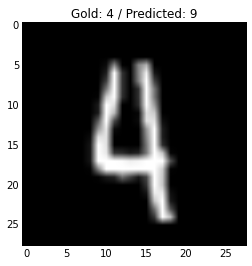

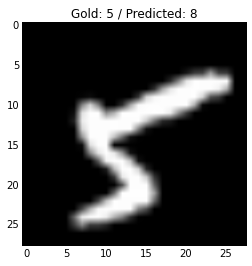

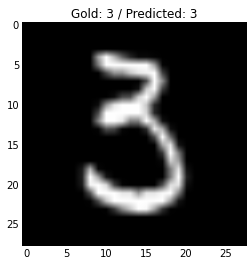

In [97]:
def do_predict(index_start, index_end):
    return y_pred.eval({x: datasets[1][0][index_start:index_end,:].eval()})

def viz_range(index_start, index_end):
    for i, p in zip(range(index_start, index_end), rc[0].apply(do_predict, index_start, index_end).result):
        viz_prediction(datasets[1], i, p)

viz_range(5, 8)

## Closing thoughts

Thus far, we have only run training for two epochs. You can re-issue the training job with a greater epoch setting to specify a larger training time. (You may need to lower the checkpointing frequency to prevent excessive amounts of data from being shuffled around).

In an actual research setting, it makes sense to do checkpointing based on the validation performance, which we have not done here.

For this tutorial, we have chosen to forego object-oriented programming and not define any classes. In continuous use, it is actually better to move code into classes. This is especially true because whenever you redefine a class  or function (e.g. because your previous definition had a mistake) the `SnippetCollector` automatically discards the old definition. On the other hand, individual cell runs that contain erroneous code must be pruned manually (e.g. in the widget shown right before you launch a job)